<a href="https://colab.research.google.com/github/kgpark88/ems/blob/master/power_usage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 임포트

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import auth
from google.colab import drive

### 데이터 로드를 위해 구글 드라이브를 연동합니다.

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 15분 전력사용량 데이터를 로드합니다. 

In [3]:
colab_dir ='/content/gdrive/My Drive/Colab Notebooks/'
file_name = 'power_usage_201.csv'
data_file = os.path.join(colab_dir, file_name)

df = pd.read_csv(data_file, header = 0, delimiter = ',', quoting = 3)
df.index = df['daq_time']

## 데이터를 확인합니다.

In [4]:
df.head()

,daq_time,power_usage
daq_time,,
2011-01-01 00:15,2011-01-01 00:15,235.492958
2011-01-01 00:30,2011-01-01 00:30,239.436620
2011-01-01 00:45,2011-01-01 00:45,228.732394
2011-01-01 01:00,2011-01-01 01:00,230.422535
2011-01-01 01:15,2011-01-01 01:15,225.352113


In [5]:
df.tail()

,daq_time,power_usage
daq_time,,
2014-12-31 23:00,2014-12-31 23:00,149.295775
2014-12-31 23:15,2014-12-31 23:15,151.549296
2014-12-31 23:30,2014-12-31 23:30,147.042254
2014-12-31 23:45,2014-12-31 23:45,142.535211
2015-01-01 00:00,2015-01-01 00:00,143.098592


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15 to 2015-01-01 00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   daq_time     140256 non-null  object 
 1   power_usage  140256 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.2+ MB


In [7]:
df.describe()

,power_usage
count,140256.000000
mean,242.393145
std,72.339054
min,0.000000
25%,189.859155
50%,249.014085
75%,288.450704
max,479.436620


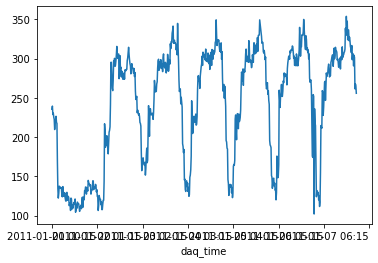

In [8]:
df_week = df.iloc[0:96*7]
df_week["power_usage"].plot()

In [9]:
series = df['power_usage'].values

### 데이터셋을 입력데이터와 타깃데이터로 분리하는 함수입니다.

In [10]:
def split_data_input_label(dataset, start_index, end_index, hist_data_size, target_size):
    data = []
    labels = []

    start_index = start_index + hist_data_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-hist_data_size, i)
        # Reshape data from (hist_data_size,) to (hist_data_size, 1)
        data.append(np.reshape(dataset[indices], (hist_data_size, 1)))
        labels.append([dataset[i+target_size]])
    return np.array(data), np.array(labels)

## 시계열 데이터값을 0과 1사이 값으로 정규화합니다.


In [11]:
train_split = 70080 # 365일 * 2년 * 96개데이터
test_split = 105120 # 365일 * 3년 * 96개데이터

min = np.min(series[:test_split])
max = np.max(series[:test_split])

dataset = (series - min)/max

In [12]:
# train_split = 70080 # 365일 * 2년 * 96개데이터
# test_split = 105120 # 365일 * 3년 * 96개데이터

# data_mean = series[:test_split].mean()
# data_std = series[:test_split].std()
# dataset = (series - data_mean)/data_std

In [13]:
dataset

array([0.49118684, 0.49941246, 0.47708578, ..., 0.306698  , 0.2972973 ,
       0.29847239])

## 훈련 데이터셋과 검증 데이터셋으로 데이터를 분할합니다.

In [14]:
n_steps = 20
future_target = 0

X_train, y_train = split_data_input_label(dataset, 0,train_split, 
                                          n_steps, 
                                          future_target)
X_valid, y_valid = split_data_input_label(dataset,train_split,test_split, 
                                          n_steps, 
                                          future_target)
X_test, _ = split_data_input_label(dataset, test_split, test_split+1000, 
                                   n_steps, 
                                   future_target)

In [15]:
X_train.shape

(70060, 20, 1)

## 입력데이터, 타깃데이터, 예측데이터를 그래프로 출력하는 함수입니다.

In [16]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

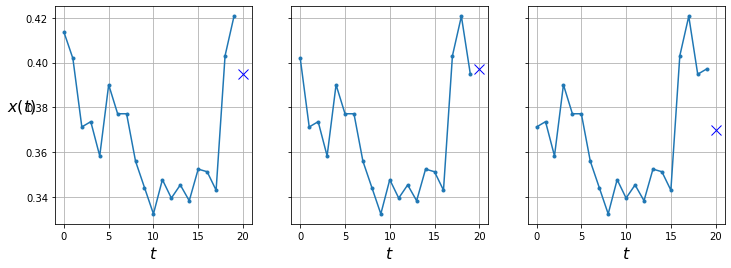

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## LSTM 모델 구성 

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(1)
])

모델 구성 확인

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 5,481
Trainable params: 5,481
Non-trainable params: 0
_________________________________________________________________


초기 가중치 설정 확인

In [20]:
hidden1 = model.layers[0]
hidden1.get_weights()

[array([[ 0.08957627, -0.03211184, -0.08008063, -0.01933324, -0.25384313,
          0.10052291,  0.13070339,  0.20273313, -0.14896908, -0.15067255,
         -0.10321166,  0.12102428, -0.19966762,  0.02616265,  0.04061189,
          0.21756014, -0.26701418,  0.01155654,  0.07323673, -0.16366494,
          0.12488177,  0.02494916, -0.21361428,  0.09618661,  0.08724338,
         -0.08875296,  0.05520478, -0.15751538,  0.19200581, -0.03232144,
          0.24414748, -0.14287278,  0.1697186 ,  0.01433736, -0.00309834,
         -0.1545201 ,  0.18818596,  0.20242807, -0.10430135,  0.10168311,
         -0.1428105 ,  0.15335047,  0.25427794, -0.2347691 ,  0.16261315,
          0.08724928,  0.04743916, -0.18255943,  0.12960649, -0.09768543,
          0.05845568, -0.01892379,  0.26020956,  0.12101269, -0.09609051,
          0.17732856, -0.00125659, -0.16610985,  0.14091358, -0.08815746,
         -0.11905575, -0.10062738,  0.05808514,  0.13600644,  0.00087392,
         -0.17265004, -0.20042372,  0.

모델 컴파일

In [21]:
model.compile(optimizer='adam', loss='mse')

모델 훈련 조기종료, 체크포인트 설정

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                    verbose=1, patience=5)
check_point = ModelCheckpoint('best_model.h5', verbose=1,
            monitor='val_loss', mode='min', save_best_only=True)

모델 컴파일

In [23]:
history = model.fit(x=X_train, y=y_train, 
          epochs=30 , 
          batch_size=96,
          verbose=1,                                     
          validation_data=(X_valid, y_valid), 
          callbacks=[early_stop, check_point])

Epoch 1/30
724/730 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 00001: val_loss improved from inf to 0.00161, saving model to best_model.h5
730/730 [==============================] - 5s 7ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 2/30
723/730 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00002: val_loss improved from 0.00161 to 0.00114, saving model to best_model.h5
730/730 [==============================] - 5s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/30
729/730 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00003: val_loss improved from 0.00114 to 0.00093, saving model to best_model.h5
730/730 [==============================] - 5s 6ms/step - loss: 0.0012 - val_loss: 9.2883e-04
Epoch 4/30
729/730 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00004: val_loss improved from 0.00093 to 0.00082, saving model to best_model.h5
730/730 [==============================] - 5s 6ms/step - loss: 0.0011 - val_loss:

신경망 모델의 학습상태를 출력하는 함수입니다.

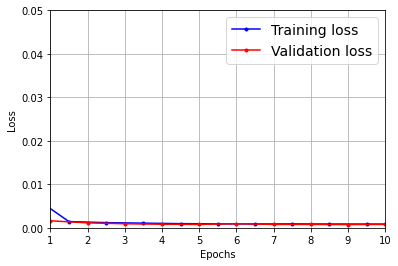

In [24]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.axis([1, 10, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 검증 데이터셋으로 신경망 모델을 평가합니다.

In [25]:
model.evaluate(X_valid, y_valid)

1095/1095 [==============================] - 3s 3ms/step - loss: 7.4040e-04


0.0007404044736176729

## 예측 결과를 확인합니다.

입력 데이터 : [102.54 104.79  96.34  90.7  100.28  99.72  97.46  99.15  99.72  98.03
 108.17 108.73 135.21 170.14 166.2  152.68 161.69 167.89 162.82 161.69]
예측값 : 165.45
실제값 : 161.0
오차 : 4.88
오차율 : 3.04%


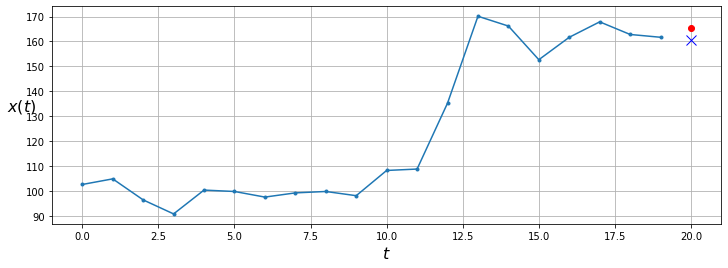

In [27]:
time_step = 200
n_step = 20
y_pred = model.predict(X_valid[time_step].reshape(1, n_step, 1))


fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
plot_series(X_valid[time_step, :, 0]*max + min, 
            y_valid[time_step, 0]*max + min, 
            y_pred[0, 0]*max + min)

input_data = X_valid[time_step, :, 0]*max + min
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*max + min
print("예측값 : {}".format(round(predict_value, 2)))
real_value = y_valid[time_step, 0]*max + min
print("실제값 : {}".format(round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("오차 : {}".format(round(error, 2)))
print("오차율 : {}%".format(round(error_rate, 2)))

## 모델 저장

In [28]:
model.save('my_model.h5')

## 저장한 모델 로드

In [29]:
model = load_model('best_model.h5')
# model = load_model('my_model.h5')

## 저장한 모델을 사용하여 예측

입력 데이터 : [102.54 104.79  96.34  90.7  100.28  99.72  97.46  99.15  99.72  98.03
 108.17 108.73 135.21 170.14 166.2  152.68 161.69 167.89 162.82 161.69]
예측값 : 162.04
실제값 : 161.0
오차 : 1.48
오차율 : 0.92%


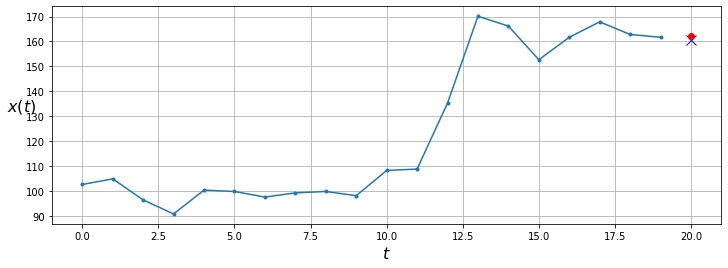

In [30]:
time_step = 200
y_pred = model.predict(X_valid[time_step].reshape(1, n_steps, 1))

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
plot_series(X_valid[time_step, :, 0]*max + min, 
            y_valid[time_step, 0]*max + min, 
            y_pred[0, 0]*max + min)

input_data = X_valid[time_step, :, 0]*max + min
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*max + min
print("예측값 : {}".format(round(predict_value, 2)))
real_value = y_valid[time_step, 0]*max + min
print("실제값 : {}".format(round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("오차 : {}".format(round(error, 2)))
print("오차율 : {}%".format(round(error_rate, 2)))